In [ ]:
!pip install pyspark

data: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

data columns: https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

taxi_zone_data: https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc

In [ ]:
import os
import pyspark
conf = pyspark.SparkConf()
#conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
#conf.set('spark.sql.repl.eagerEval.enabled', True)
conf.set('spark.driver.memory','4g')

sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/06 17:29:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/envs/bigdata/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
spark

In [ ]:
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import hour, when
from pyspark.sql.functions import count, avg
from pyspark.sql.functions import sum
from pyspark.sql.functions import col
from pyspark.sql.functions import date_format, to_timestamp
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df1 = spark.read.parquet('./content/taxi_data_2023/yellow_tripdata_2023-01.parquet')

In [ ]:
df2 = spark.read.parquet('./content/taxi_data_2023/yellow_tripdata_2023-02.parquet')

In [ ]:
df3 = spark.read.parquet('./content/taxi_data_2023/yellow_tripdata_2023-03.parquet')

In [ ]:
df4 = spark.read.parquet('./content/taxi_data_2023/yellow_tripdata_2023-04.parquet')

In [ ]:
df5 = spark.read.parquet('./content/taxi_data_2023/yellow_tripdata_2023-05.parquet')

In [ ]:
df6 = spark.read.parquet('./content/taxi_data_2023/yellow_tripdata_2023-06.parquet')

In [ ]:
df7 = spark.read.parquet('./content/taxi_data_2023/yellow_tripdata_2023-07.parquet')

In [ ]:
df8 = spark.read.parquet('./content/taxi_data_2023/yellow_tripdata_2023-08.parquet')

In [ ]:
df9 = spark.read.parquet('./content/taxi_data_2023/yellow_tripdata_2023-09.parquet')

In [ ]:
# Combining all the dataframe months into a single dataframe
df = df1.unionAll(df2).unionAll(df3).unionAll(df4).unionAll(df5).unionAll(df6).unionAll(df7).unionAll(df8).unionAll(df9)

In [ ]:
# Cleaning up the data
df = df.dropna()
df = df.withColumn("Passenger_count", df["Passenger_count"].cast(IntegerType()))
df = df.withColumn("Trip_distance", df["Trip_distance"].cast(FloatType()))

In [ ]:
# Extracting the hour from the pickoff/dropoff columns
df = df.withColumn("pickup_hour", hour("tpep_pickup_datetime"))
df = df.withColumn("dropoff_hour", hour("tpep_dropoff_datetime"))

In [ ]:
# Checking how our data looks
df.limit(5).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,Passenger_count,Trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_hour,dropoff_hour
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1,0.97,1.0,N,161,141,2,...,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0,0
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1,1.10,1.0,N,43,237,1,...,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,0,1
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1,2.51,1.0,N,48,238,1,...,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0,0
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0,1.90,1.0,N,138,7,1,...,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0,0
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1,1.43,1.0,N,107,79,1,...,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0,0


In [ ]:
# data analysis: showing the total number of trips in each hour of the day
df.groupBy("pickup_hour").agg(count("*").alias("num_trips")).toPandas()

,pickup_hour,num_trips
0,12,1500100
1,22,1408249
2,1,512370
3,13,1545847
4,6,375709
5,16,1696000
6,3,220478
7,20,1529819
8,5,153711
9,19,1719645


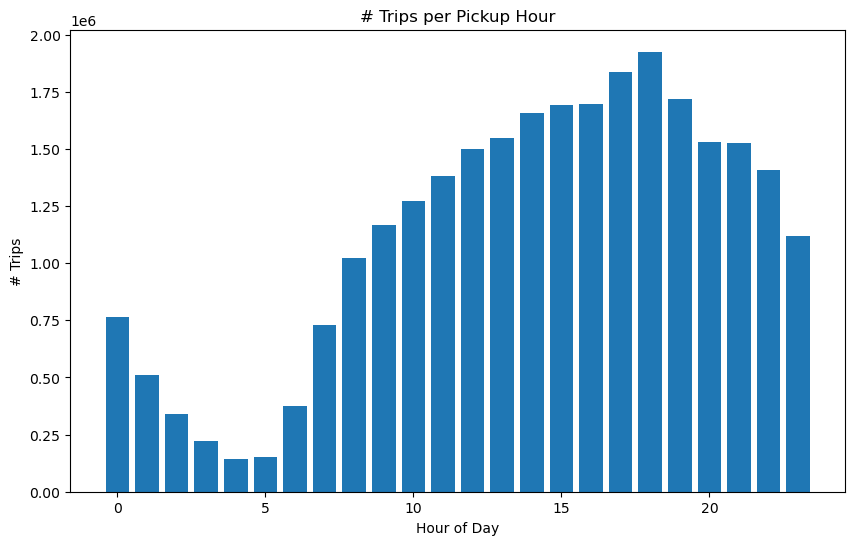

In [ ]:
df_pickup = df.groupBy("pickup_hour").agg(count("*").alias("num_trips")).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(df_pickup["pickup_hour"], df_pickup["num_trips"])
plt.xlabel("Hour of Day")
plt.ylabel("# Trips")
plt.title("# Trips per Pickup Hour")
plt.show()

In [ ]:
# data analysis: showing the total number of trips in each locationID
df.groupBy("PULocationID").agg(count("*").alias("trip_nums")).toPandas()

,PULocationID,trip_nums
0,26,805
1,29,844
2,65,15833
3,191,1780
4,222,1228
...,...,...
257,105,7
258,176,12
259,59,41
260,84,12


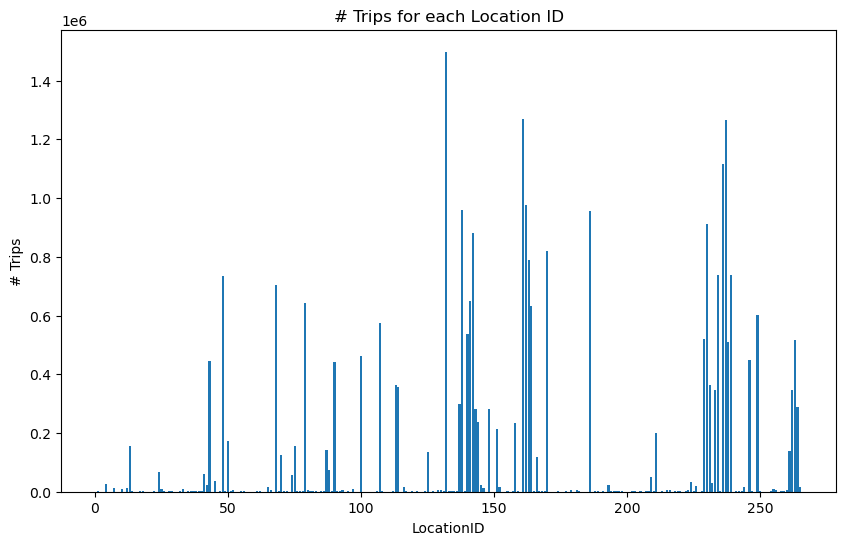

In [ ]:
df_location = df.groupBy("PULocationID").agg(count("*").alias("trip_nums")).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(df_location["PULocationID"], df_location["trip_nums"])
plt.xlabel("LocationID")
plt.ylabel("# Trips")
plt.title("# Trips for each Location ID")
plt.show()

In [ ]:
#best pickup locations
def best_pickup_locations(df):
    df=df.groupBy("PULocationID").agg({"PULocationID": "count"})
    df=df.sort(col('count(PULocationID)').desc())
    df=df.select(col('PULocationID'), col('count(PULocationID)').alias('count')).limit(10)
    return df
best_pickup_locations(df).show()

+------------+-------+
|PULocationID|  count|
+------------+-------+
|         132|1498427|
|         161|1267807|
|         237|1267476|
|         236|1116385|
|         162| 975023|
|         138| 958217|
|         186| 954814|
|         230| 912782|
|         142| 881763|
|         170| 818234|
+------------+-------+



In [ ]:
zones = spark.read.csv("./content/taxi_zones.csv", header=True)

In [ ]:
# Creating dataframe for pickup
pickup_zone = zones.selectExpr("LocationID as LocationID_PU", "Zone as Zone_PU", "the_geom as Geometry")

In [ ]:
import re
def extract_coords(input_string):
    """
    Given a Multipolygon object as a string, extract the list of coordinates
    """
    pattern = r'(-?\d+\.\d+\s-?\d+\.\d+)'

    # Find all matches in the string
    matches = re.findall(pattern, input_string)

    # Extract coordinates from the matched pairs
    coordinates = [tuple(map(float, match.split())) for match in matches]

    return coordinates

In [ ]:
import numpy as np
def calculate_center(vertices):
    """
    Given a list of vertices of a Multipolygon, calculate the center as a coordinate
    """
    return np.mean(vertices, axis=0).tolist()

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, DoubleType

coords_udf = udf(extract_coords, ArrayType(ArrayType(DoubleType())))
center_udf = udf(calculate_center, ArrayType(DoubleType()))

In [ ]:
zone_with_centers = pickup_zone.withColumn('vertices', coords_udf(col('Geometry'))) \
                                .withColumn('centroids', center_udf(col('vertices'))) \
                                .withColumn('long', col('centroids')[0]) \
                                .withColumn('lat', col('centroids')[1])

zone_with_centers.limit(5).toPandas()

,LocationID_PU,Zone_PU,Geometry,vertices,centroids,long,lat
0,1,Newark Airport,MULTIPOLYGON (((-74.18445299999996 40.69499599...,"[[-74.18445299999996, 40.694995999999904], [-7...","[-74.174270275862, 40.69024330172404]",-74.174270,40.690243
1,2,Jamaica Bay,MULTIPOLYGON (((-73.82337597260663 40.63898704...,"[[-73.82337597260663, 40.63898704717672], [-73...","[-73.8176429235687, 40.61216268077727]",-73.817643,40.612163
2,3,Allerton/Pelham Gardens,MULTIPOLYGON (((-73.84792614099985 40.87134223...,"[[-73.84792614099985, 40.87134223399991], [-73...","[-73.8465098633635, 40.864294038404864]",-73.846510,40.864294
3,4,Alphabet City,MULTIPOLYGON (((-73.97177410965318 40.72582128...,"[[-73.97177410965318, 40.72582128133706], [-73...","[-73.97520908904802, 40.723853149707395]",-73.975209,40.723853
4,5,Arden Heights,MULTIPOLYGON (((-74.17421738099989 40.56256808...,"[[-74.17421738099989, 40.5625680859999], [-74....","[-74.18980260697641, 40.55667805421754]",-74.189803,40.556678


In [ ]:
df_zones = df.join(zone_with_centers, df.PULocationID == zone_with_centers.LocationID_PU, how='left')

In [ ]:
from pyspark.sql.functions import hour, minute, lit
# User input time
USER_TIME = '15:00:00' # Example time

In [ ]:
windowed_df = df_zones.withColumn("hour", hour("tpep_pickup_datetime")) \
                        .withColumn("minute", minute("tpep_pickup_datetime")) \
                        .withColumn("user_hour", hour(lit(USER_TIME))) \
                        .withColumn("user_minute", minute(lit(USER_TIME))) \
                        .withColumn("time_diff", (col("hour") * 60 + col("minute")) - (col("user_hour") * 60 + col("user_minute"))) \
                        .filter((col("time_diff") >= -30) & (col("time_diff") <= 30)) \
                        .select('tpep_pickup_datetime', 'tpep_dropoff_datetime', 'time_diff', 'Trip_distance', 'Passenger_count', 'PULocationID','DOLocationID', 'Zone_PU','long', 'lat', 'tip_amount', 'total_amount')

In [ ]:
windowed_df.limit(5).toPandas()

,tpep_pickup_datetime,tpep_dropoff_datetime,time_diff,Trip_distance,Passenger_count,PULocationID,DOLocationID,Zone_PU,long,lat,tip_amount,total_amount
0,2022-12-31 14:39:43,2022-12-31 14:43:37,-21,0.54,1,163,162,Midtown North,-73.978757,40.765561,2.16,12.96
1,2022-12-31 15:14:12,2022-12-31 15:25:34,14,1.54,1,193,7,Queensbridge/Ravenswood,-73.939093,40.762743,0.00,13.20
2,2023-01-01 14:39:59,2023-01-01 14:52:58,-21,2.20,1,246,249,West Chelsea/Hudson Yards,-74.008111,40.750105,4.20,21.00
3,2023-01-01 14:31:15,2023-01-01 15:06:57,-29,11.69,1,140,177,Lenox Hill East,-73.955720,40.763907,10.92,65.52
4,2023-01-01 14:43:04,2023-01-01 14:50:40,-17,1.61,2,151,239,Manhattan Valley,-73.971010,40.799377,2.80,16.80


In [ ]:
pickup_count = df_zones.groupby("Zone_PU").count().orderBy('count', ascending=False).limit(10).toPandas()

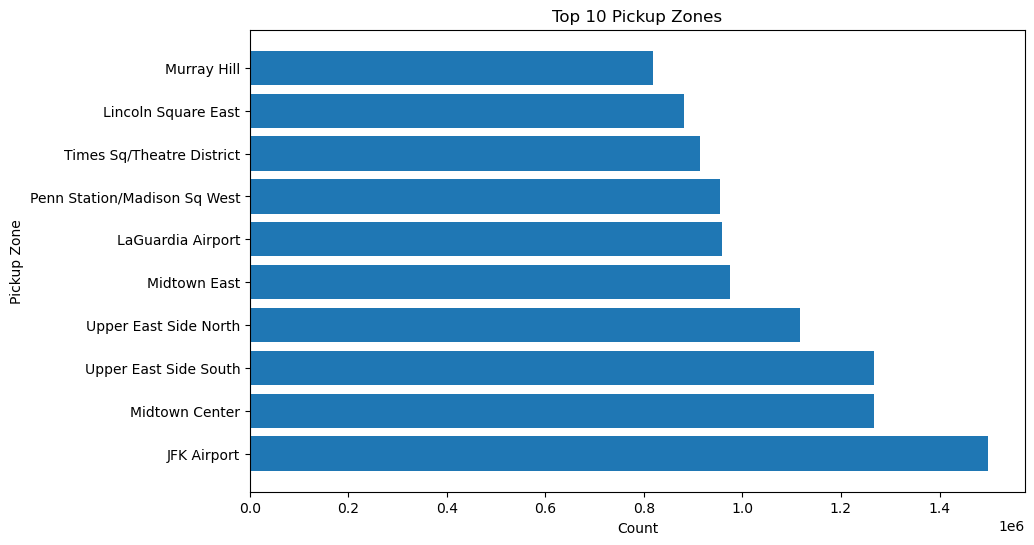

In [ ]:
plt.figure(figsize=(10,6))
plt.barh(pickup_count['Zone_PU'], pickup_count['count'])
plt.title('Top 10 Pickup Zones')
plt.xlabel('Count')
plt.ylabel('Pickup Zone')
plt.show()

In [ ]:
# Running pyspark.ml.KMeans to determine best area to be as a yellow cab driver
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

In [ ]:
assembler = VectorAssembler(inputCols = ['long','lat'], outputCol='features', handleInvalid="skip")

assembled_df = assembler.transform(windowed_df)

In [ ]:
kmeans = KMeans(k=5, seed=42)
model = kmeans.fit(assembled_df.select('features'))

23/12/06 17:44:40 WARN BlockManager: Asked to remove block broadcast_181_piece0, which does not exist


In [ ]:
transformed = model.transform(assembled_df)

In [ ]:
transformed.limit(10).toPandas()

,tpep_pickup_datetime,tpep_dropoff_datetime,time_diff,Trip_distance,Passenger_count,PULocationID,DOLocationID,Zone_PU,long,lat,tip_amount,total_amount,features,prediction
0,2022-12-31 14:39:43,2022-12-31 14:43:37,-21,0.54,1,163,162,Midtown North,-73.978757,40.765561,2.16,12.96,"[-73.9787569469772, 40.76556053479537]",0
1,2022-12-31 15:14:12,2022-12-31 15:25:34,14,1.54,1,193,7,Queensbridge/Ravenswood,-73.939093,40.762743,0.00,13.20,"[-73.93909312925491, 40.76274259483616]",4
2,2023-01-01 14:39:59,2023-01-01 14:52:58,-21,2.20,1,246,249,West Chelsea/Hudson Yards,-74.008111,40.750105,4.20,21.00,"[-74.00811097157023, 40.75010482577549]",2
3,2023-01-01 14:31:15,2023-01-01 15:06:57,-29,11.69,1,140,177,Lenox Hill East,-73.955720,40.763907,10.92,65.52,"[-73.95571997200136, 40.76390679108292]",0
4,2023-01-01 14:43:04,2023-01-01 14:50:40,-17,1.61,2,151,239,Manhattan Valley,-73.971010,40.799377,2.80,16.80,"[-73.97100993152024, 40.7993770621872]",4
5,2023-01-01 14:52:15,2023-01-01 15:14:10,-8,4.74,2,239,158,Upper West Side South,-73.983170,40.784791,2.94,32.34,"[-73.98317024389998, 40.78479094272763]",0
6,2023-01-01 14:55:44,2023-01-01 15:05:15,-5,2.23,1,114,164,Greenwich Village South,-73.996964,40.727635,3.22,19.32,"[-73.99696399176183, 40.727634697071345]",2
7,2023-01-01 14:45:56,2023-01-01 14:54:15,-15,2.40,0,107,140,Gramercy,-73.984269,40.736706,2.00,18.10,"[-73.98426922264278, 40.73670614808919]",2
8,2023-01-01 14:48:08,2023-01-01 14:58:08,-12,2.10,2,79,164,East Village,-73.986487,40.726759,3.35,20.15,"[-73.98648683022024, 40.72675919871179]",2
9,2023-01-01 14:58:21,2023-01-01 15:06:08,-2,1.12,3,151,166,Manhattan Valley,-73.971010,40.799377,2.70,13.50,"[-73.97100993152024, 40.7993770621872]",4


In [ ]:
# Determine the average revenue for each cluster
avg_revenue = transformed.groupBy('Prediction') \
                    .agg({'total_amount': 'avg'}) \
                    .withColumnRenamed('avg(total_amount)', 'Average Revenue') \
                    .withColumnRenamed('Prediction', 'Cluster') \
                    .select('Cluster', 'Average Revenue')

# Determine the average tip for each cluster
avg_tip = transformed.groupBy('Prediction') \
                    .agg({'tip_amount': 'avg'}) \
                    .withColumnRenamed('avg(tip_amount)', 'Average Tip') \
                    .withColumnRenamed('Prediction', 'Cluster') \
                    .select('Cluster', 'Average Tip')

In [ ]:
avg_revenue.toPandas()

,Cluster,Average Revenue
0,1,79.495502
1,3,65.695076
2,4,21.143833
3,2,25.340200
4,0,23.849097


In [ ]:
avg_tip.toPandas()

,Cluster,Average Tip
0,1,8.732092
1,3,8.467478
2,4,2.602149
3,2,3.156686
4,0,2.966183


In [ ]:
# Determine cluster centers
cluster_centers = transformed.groupBy('Prediction') \
                            .agg({'long': 'avg', 'lat': 'avg'}) \
                            .withColumnRenamed('avg(long)', 'Centroid Longitude') \
                            .withColumnRenamed('avg(lat)', 'Centroid Latitude') \
                            .withColumnRenamed('Prediction', 'Cluster') \
                            .select('Cluster', 'Centroid Longitude', 'Centroid Latitude')

cluster_centers.toPandas()

,Cluster,Centroid Longitude,Centroid Latitude
0,1,-73.784329,40.640388
1,3,-73.871681,40.773241
2,4,-73.958292,40.785653
3,2,-73.996985,40.733642
4,0,-73.975715,40.762317
